# 汉语子词向量任务 SVD

本实验基于 SVD 分解构建汉语子词向量并进行评测。

In [1]:
import numpy as np
import jieba
import re
import matplotlib.pyplot as plt
import tqdm

首先导入 corpus 语料库，并得到句子序列 sentences，查看语料库总共有 260004 条。

In [2]:
def read_file(file_name):
    lines = []
    with open(file_name, 'r') as f: 
        for line in f:
            lines.append(line)
    return lines

In [3]:
sentences = read_file('src/corpus.txt')
len(sentences)

260004

### 句子预处理
对 sentences 序列中的每个句子元素进行预处理，包括如下步骤。
- 除去数据中空格（包括非文本、标点等）
- 除去停用词
- 中文分词

使用这些方法可以得到处理后的 sentences。

In [4]:
def purify(line): 
    line = line.replace(' ', '')
    return line

In [5]:
import jieba
from jieba import analyse

analyse.set_stop_words('src/stopwords.txt') # 停用词表设定

for i in range(len(sentences)):
    sentences[i] = purify(sentences[i])
    sentences[i] = analyse.extract_tags(sentences[i])

sentences[0][-5:]

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.753 seconds.
Prefix dict has been built successfully.


['上涨', '最后', '一样', '继续', '美国']

### 生成词表

通过对 corpus.txt 中的所有语句进行分词，得到词表。

In [10]:
words = set([]) # 词表集合
        
for i in range(len(sentences)):
    for j in range(len(sentences[i])):
        words.add(sentences[i][j])

words = list(words)
len(words)

214578

从中取出 10000 个高频词，最终得到词表 words，打印其中某个词。

In [12]:
import random

def get_word_pair(line):
    line = line.strip("\n")
    return line.split()
     
words = random.sample(words, 9000) 

with open('src/word_pair.txt', 'r') as f: # 加入测试词汇
    for line in f:
        worda, wordb = get_word_pair(line)
        words.append(worda)
        words.append(wordb) 
        
len(words), words[0]

(10000, '空气')

### 对应词表构建矩阵
构建二维词频统计矩阵 M。

In [13]:
M = np.zeros((10000, 10000), dtype=int)
M.shape

(10000, 10000)

### 基于 SVD 分解
通过窗口 K = 5 滑动得到词频统计，完善词频矩阵的计数。首先设计更新用的函数。

In [14]:
def M_update(sentence, M, words, k=5): # 更新 M 矩阵的词频计数
    if len(sentence) < k:
        return M
    
    for i in range(len(sentence)): # 先将句子中非词表的词改为 0 值
        if sentence[i] not in words:
            sentence[i] = 0
    
    for i in range(len(sentence)):
        if sentence[i] != 0: # 该中心词在词表中
            indices = list(range(max(0, i - k), min(len(sentence), i + 1 + k))) # 上下文窗口中间 i
            
            indices.remove(i) # 排除中心词
            
            w = words.index(sentence[i])
            
            for j in range(len(indices)):
                word_j = sentence[indices[j]]
                
                if word_j != 0: # 窗口内的词也在词表中
                    wj = words.index(word_j)
                    
                    M[wj][w] += 1 # 更新 M 对应位置的计数
                    M[w][wj] += 1
                    
                    
                else:
                    continue
            
        else: 
            continue
            
    return M

对所有句子 sentences 序列进行遍历，得到最终的矩阵 M。

In [15]:
for sent in tqdm.tqdm(sentences):
    M = M_update(sent, M, words)

100%|██████████| 260004/260004 [22:32<00:00, 192.28it/s]


对原始的 M 进行散点图可视化。

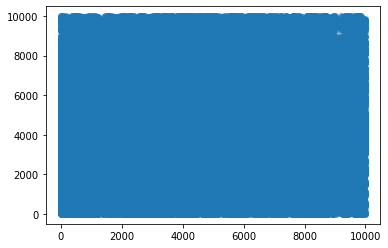

In [16]:
x, y = np.where(M > 0)

fig = plt.figure()
ax = fig.subplots()

ax.scatter(x, y, alpha=0.5)
plt.show()

基于 SVD 降维，获得子词向量 vec_sta。

In [17]:
U, sigma, VT = np.linalg.svd(M)

经过检验，发现零奇异值在 4500 取到。本实验选取了 3000 个奇异值，将维度减小到 3000。

In [27]:
sigma[4500], sigma[3000]

(0.0001614032909211087, 2.000000000000001)

经过计算，得到选取的奇异值与奇异值总和的比值为 0.98，是合理的。

In [28]:
s1 = np.sum(sigma[:3000])
s2 = np.sum(sigma[:])
s1, s2, s1 / s2

(71303.72784452922, 72804.68586968372, 0.9793837717006137)

### 相似度验证 SVD 分解

In [32]:
def cos_sim(worda, wordb, V): # 计算两个词的余弦相似度
    if (worda in words) and (wordb in words):
        a = words.index(worda)
        b = words.index(wordb)
        cos = np.dot(V[a], V[b]) / (np.linalg.norm(V[a]) * np.linalg.norm(V[b]))
        return cos
    else:
        return 0

求得最终的词空间向量。

In [33]:
V = U[:3000].T * sigma[:3000] # n = 100000, k = 3000
V.shape

(10000, 3000)

基于该向量计算 test.txt 中的同一行的两个子词的余弦相似度 sim_svd，并插入到行后。

In [35]:
lines = ''

with open('src/test.txt', 'r') as f: 
    for line in f:
        worda, wordb = get_word_pair(line)
        line = line[:-1] + '\t' + str(cos_sim(worda, wordb, V)) + '\n'
        lines += line
    
with open('src/test.txt', 'w') as f: 
    f.write(lines)

/tmp/ipykernel_237/765101111.py:5: RuntimeWarning: invalid value encountered in double_scalars
  cos = np.dot(V[a], V[b]) / (np.linalg.norm(V[a]) * np.linalg.norm(V[b]))
